In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report




In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


c:\Users\Mohd Uwaish\AppData\Local\Programs\Python\Python311\python.exe: No module named pip


In [17]:
# Load the dataset
file_path = "data.csv"  # Ensure the correct dataset path
df = pd.read_csv(file_path)

# Convert categories to numerical labels
category_mapping = {cat: idx for idx, cat in enumerate(df['category'].unique())}
print(category_mapping)
df['label'] = df['category'].map(category_mapping)

# Feature Engineering: Add query length as a new feature
df["query_length"] = df["query"].apply(lambda x: len(x.split()))

# Split dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['query'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)



{'Explicit Fact': 0, 'Implicit Fact': 1, 'Interpretable Rationale': 2, 'Hidden Rationale': 3}


In [18]:
# Download stopwords if not already available
nltk.download("stopwords")

# Initialize stemmer
stemmer = PorterStemmer()

# Text Preprocessing Function with Stemming & Removing Special Characters
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text).strip()
    text = text.lower()  # Convert to lowercase
    text = text.split()  # Tokenization
    text = [stemmer.stem(word) for word in text if word not in stopwords.words('english')]  # Remove stopwords & stem
    return " ".join(text)

# Apply preprocessing
train_texts = train_texts.apply(preprocess_text)
val_texts = val_texts.apply(preprocess_text)

# Define models and hyperparameters
models = {
    "Naive Bayes": {
        "model": MultinomialNB(),
        "params": {"model__alpha": [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=3000, class_weight="balanced"),
        "params": {"model__C": [0.01, 0.1, 1, 10, 50]}
    },
    "Support Vector Machine": {
        "model": SVC(),
        "params": {"model__C": [0.1, 1, 10, 50], "model__kernel": ["linear", "rbf", "poly"]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {"model__n_estimators": [50, 100, 200, 300], "model__max_depth": [None, 10, 20, 50]}
    }
}



[nltk_data] Downloading package stopwords to C:\Users\Mohd
[nltk_data]     Uwaish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
best_models = {}
results = []

# Train and evaluate models using RandomizedSearchCV for better hyperparameter tuning
for name, model_info in models.items():
    print(f"Training and tuning {name}...")

    # Create Pipeline with TF-IDF + Model
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=7000, ngram_range=(1,3))),  # Use bigrams & trigrams for better feature representation
        ("model", model_info["model"])
    ])

    # Perform Randomized Search
    rand_search = GridSearchCV(pipeline, model_info["params"], cv=5, scoring="accuracy", n_jobs=-1)
    rand_search.fit(train_texts, train_labels)

    # Store best model
    best_models[name] = rand_search.best_estimator_

    # Evaluate on validation set
    val_preds = rand_search.best_estimator_.predict(val_texts)
    accuracy = accuracy_score(val_labels, val_preds)

    results.append((name, accuracy, rand_search.best_estimator_))

    print(f"Best {name} Model Accuracy: {accuracy:.4f}")
    print(f"Best Hyperparameters: {rand_search.best_params_}")
    print(classification_report(val_labels, val_preds, target_names=category_mapping.keys()))
    print("-" * 80)

# Select the model with the highest accuracy
best_model_name, best_accuracy, best_model = max(results, key=lambda x: x[1])

print(f" Best Model Selected: {best_model_name} with Accuracy: {best_accuracy:.4f}")




Training and tuning Naive Bayes...
Best Naive Bayes Model Accuracy: 0.8629
Best Hyperparameters: {'model__alpha': 0.5}
                         precision    recall  f1-score   support

          Explicit Fact       0.96      0.89      0.92        27
          Implicit Fact       0.96      1.00      0.98        26
Interpretable Rationale       0.81      0.74      0.78        35
       Hidden Rationale       0.78      0.86      0.82        36

               accuracy                           0.86       124
              macro avg       0.88      0.87      0.87       124
           weighted avg       0.87      0.86      0.86       124

--------------------------------------------------------------------------------
Training and tuning Logistic Regression...
Best Logistic Regression Model Accuracy: 0.9113
Best Hyperparameters: {'model__C': 50}
                         precision    recall  f1-score   support

          Explicit Fact       0.93      0.96      0.95        27
          Implic

In [7]:
import pickle
print(best_model)

# Save the best model to a pickle file
pickle_file_path = "best_model.pkl"  # Specify the path to save the pickle file
with open(pickle_file_path, "wb") as file:
    pickle.dump(best_model, file)

print(f"Best model saved to {pickle_file_path}")


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=7000, ngram_range=(1, 3))),
                ('model',
                 LogisticRegression(C=50, class_weight='balanced',
                                    max_iter=3000))])
Best model saved to best_model.pkl


In [14]:
import pandas as pd
import numpy as np
import re
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Load dataset
file_path = "data.csv"
df = pd.read_csv(file_path)

# Prepare category mapping
category_mapping = {cat: idx for idx, cat in enumerate(df['category'].unique())}
df['label'] = df['category'].map(category_mapping)

# Preprocessing function
def preprocess_text(text):
    stemmer = PorterStemmer()
    text = re.sub(r'\W+', ' ', text).strip().lower()
    tokens = [stemmer.stem(word) for word in text.split() if word not in stopwords.words('english')]
    return " ".join(tokens)

# Prepare data
X = df['query'].apply(preprocess_text)
y = df['label']

# Create pipeline with best hyperparameters
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=7000, ngram_range=(1,3))),
    ("model", LogisticRegression(C=50, max_iter=3000, class_weight="balanced"))
])

# Fit the pipeline
pipeline.fit(X, y)

# Export model and category mapping
with open('classification_model.pkl', 'wb') as f:
    pickle.dump((pipeline, category_mapping), f)

print("Model exported successfully!")

Model exported successfully!


In [19]:
query = "what is magmatic activity"
processed_query = preprocess_text(query)
query_vector = best_model.named_steps["tfidf"].transform([processed_query])
predicted_label = best_model.named_steps["model"].predict(query_vector)[0]

# Convert label back to category name
predicted_category = {v: k for k, v in category_mapping.items()}[predicted_label]
print(f" Predicted Category: {predicted_category}")


AttributeError: 'str' object has no attribute 'named_steps'

In [23]:
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def preprocess_text(text):
    stemmer = PorterStemmer()
    text = re.sub(r'\W+', ' ', text).strip().lower()
    tokens = [stemmer.stem(word) for word in text.split() if word not in stopwords.words('english')]
    return " ".join(tokens)

# Load the pickle file
with open('classification_model.pkl', 'rb') as f:
    model, category_mapping = pickle.load(f)

# Test queries
queries = [
    "What are the geological characteristics of volcanic formations?",
    "Explain the geochemical processes in metamorphic rocks",
    "Describe the tectonic plate movements in the Paleozoic era",
    "How do sedimentary rocks form and evolve over time?",
    "Why did magmatic activity happen in the Paleogene period?",
    "Describe magmatic activity",
]

# Classify queries
for query in queries:
    processed_query = preprocess_text(query)
    predicted_label = model.predict([processed_query])[0]
    predicted_category = {v: k for k, v in category_mapping.items()}[predicted_label]
    print(f"Query: {query}")
    print(f"Classified Category: {predicted_category}\n")

Query: What are the geological characteristics of volcanic formations?
Classified Category: Hidden Rationale

Query: Explain the geochemical processes in metamorphic rocks
Classified Category: Interpretable Rationale

Query: Describe the tectonic plate movements in the Paleozoic era
Classified Category: Explicit Fact

Query: How do sedimentary rocks form and evolve over time?
Classified Category: Interpretable Rationale

Query: Why did magmatic activity happen in the Paleogene period?
Classified Category: Implicit Fact

Query: Describe magmatic activity
Classified Category: Implicit Fact



In [24]:
import pickle

# Load the pickle file
with open('classification_model.pkl', 'rb') as f:
    model, category_mapping = pickle.load(f)

# Print original and reversed mappings
print("Original Category Mapping (Category -> Label):")
for category, label in category_mapping.items():
    print(f"{category}: {label}")

print("\nReversed Mapping (Label -> Category):")
reversed_mapping = {v: k for k, v in category_mapping.items()}
for label, category in reversed_mapping.items():
    print(f"{label}: {category}")

Original Category Mapping (Category -> Label):
Explicit Fact: 0
Implicit Fact: 1
Interpretable Rationale: 2
Hidden Rationale: 3

Reversed Mapping (Label -> Category):
0: Explicit Fact
1: Implicit Fact
2: Interpretable Rationale
3: Hidden Rationale


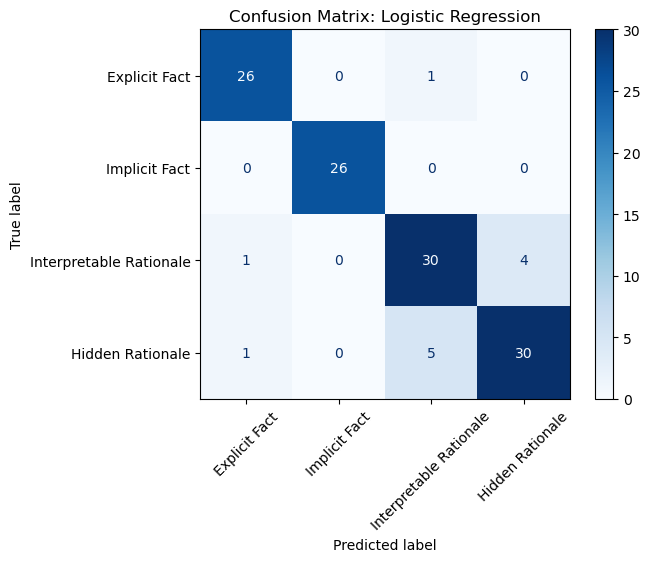

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, predicted_labels, class_names, title):
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(title)
    plt.show()


val_preds = best_models['Logistic Regression'].predict(val_texts)
class_names = list(category_mapping.keys()) 

plot_confusion_matrix(val_labels, val_preds, class_names, title="Confusion Matrix: Logistic Regression")

In [12]:
import pandas as pd

In [13]:
df1 = pd.read_csv('data.csv')

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   query     380 non-null    object
 1   category  380 non-null    object
dtypes: object(2)
memory usage: 6.1+ KB


In [7]:
df1.isnull().sum()  # Count missing values


query       0
category    0
dtype: int64

In [15]:
df1.duplicated().sum()  # Count duplicates
df1.drop_duplicates(inplace=True)  # Remove duplicates

In [24]:
df1.describe()  # Summary statistics (if numerical columns exist)


,query_length
count,564.000000
mean,9.631206
std,6.376479
min,5.000000
25%,7.000000
50%,7.000000
75%,8.000000
max,33.000000


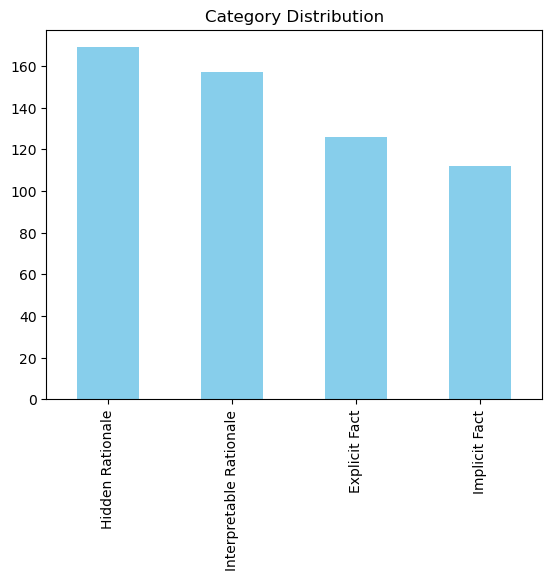

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count category occurrences
df1['category'].value_counts().plot(kind='bar', color='skyblue', title="Category Distribution")
plt.show()


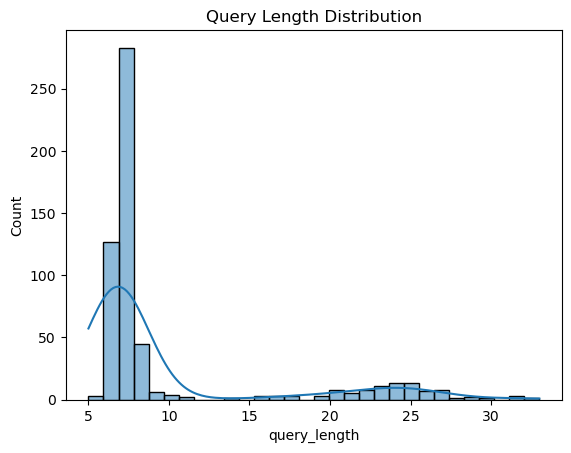

In [21]:
df1["query_length"] = df1["query"].apply(lambda x: len(x.split()))

# Summary statistics of query lengths
df1["query_length"].describe()

# Visualize
sns.histplot(df1["query_length"], bins=30, kde=True)
plt.title("Query Length Distribution")
plt.show()


In [18]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=20)
bow = vectorizer.fit_transform(df1["query"])
words_freq = dict(zip(vectorizer.get_feature_names_out(), bow.sum(axis=0).A1))

# Show most common words
sorted(words_freq.items(), key=lambda x: x[1], reverse=True)


[('does', np.int64(96)),
 ('affect', np.int64(87)),
 ('minerals', np.int64(62)),
 ('mineral', np.int64(48)),
 ('isotopes', np.int64(47)),
 ('record', np.int64(34)),
 ('affect mineral', np.int64(30)),
 ('elements', np.int64(30)),
 ('formation', np.int64(30)),
 ('track', np.int64(26)),
 ('controls', np.int64(24)),
 ('isotopes track', np.int64(24)),
 ('crystal', np.int64(23)),
 ('trace', np.int64(22)),
 ('determines', np.int64(21)),
 ('indicate', np.int64(21)),
 ('weathering', np.int64(20)),
 ('isotopes record', np.int64(18)),
 ('trace elements', np.int64(18)),
 ('controls formation', np.int64(17))]

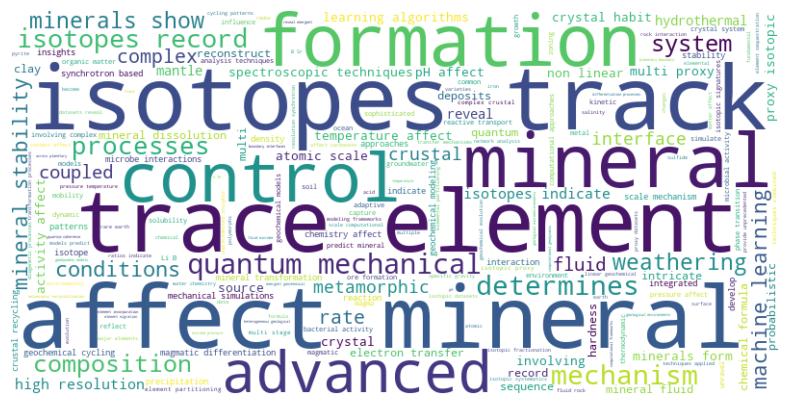

In [22]:
from wordcloud import WordCloud

text = " ".join(df1["query"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


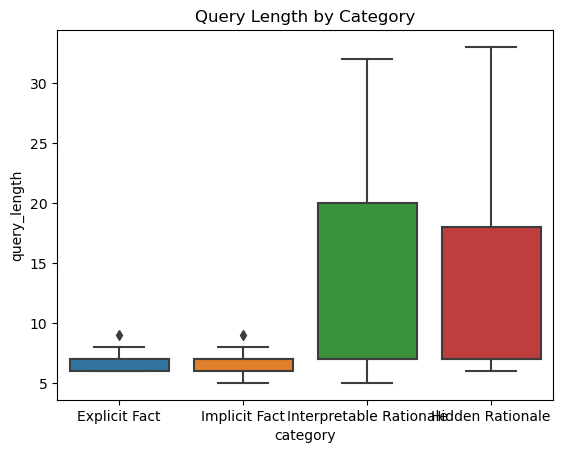

In [23]:
sns.boxplot(x=df1["category"], y=df1["query_length"])
plt.title("Query Length by Category")
plt.show()
